**A quantum subroutine for speeding up HYPMIX**

by Ashish K S Arya, ashishk1@hotmail.com

A quantum subroutine for computationally complex inner product calculation is proposed. This is an implementation of the proposed method in Qiskit. In order to run this you must have an account on IBM Quantum platform quantum-computing.ibm.com, thereafter you can run from inside IBM Quantum Lab. It's free.

*For this specific code the input vectors x,y (with norms < 1) are being prepared in inital steps and then fed to the quantumsubroutine. However, it is supposed to coming from the the classical part.*   


In [51]:
#Import necessary libraries

from qiskit import QuantumCircuit,QuantumRegister,ClassicalRegister,Aer, assemble, transpile,IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit import execute, BasicAer
from qiskit.visualization import plot_state_qsphere,plot_histogram, plot_bloch_multivector
from qiskit.quantum_info import Statevector,random_statevector
import qiskit.quantum_info as qi

from itertools import zip_longest
from scipy.stats import unitary_group



**Let's first define the function to create two vector x,y for which we want to calculate the inner product. Remember ||x|| <1 and ||y|| <1**

We generate two random vectors (of size length_vector), normalize them and then delete last two elements of the vector to ensure their norms are less than 1. The size of the vectors at output of this function will be (length_vector-2).

In [52]:
#Prepare the input to the subroutine 

import random
import numpy as np

def generate_random_vectors(length_vector):
    #Generate a random vector
    vector1 = [random.randrange(1, 100, 1) for i in range(length_vector)]
    vector2 = [random.randrange(1, 100, 1) for i in range(length_vector)]

    vector1=vector1/np.linalg.norm(vector1)
    #print(np.linalg.norm(vector1))

    vector2=vector2/np.linalg.norm(vector2)
    #print(np.linalg.norm(vector2))

    #we in order to have a vector with norm <1 we can drop an element from the list

    vector1=np.delete(vector1,[-1])
    vector2=np.delete(vector2,[-1])


    #print("norm vector1= ",np.linalg.norm(vector1), len(vector1))
    #print("norm vector2= ",np.linalg.norm(vector2), len(vector2))
    return vector1,vector2

          

**Now suppose we have two vector x,y; Let's define the function add the dummy variables.**

From this point the quantum subroutine starts. The vector generated in the above step are the inputs to the quantum sub routine.

However since can only load normalized vectors into a quantum circuit we need to introduce a dummy variable to make the norm of x and y equalt to 1.

In [53]:
def add_dummy_variables(vector1,vector2):
    norm1=np.linalg.norm(vector1)
    norm2=np.linalg.norm(vector2)
    
    dummy_variable1=np.sqrt(1-norm1**2)
    dummy_variable2=np.sqrt(1-norm2**2)

    vector1=np.append(vector1,dummy_variable1)
    vector2=np.append(vector2,dummy_variable2)

    norm1=np.linalg.norm(vector1)
    norm2=np.linalg.norm(vector2)

    return vector1,vector2


**Let's define the function to build the quantum vectors to load the inputs into quantum circuit**

number of qubits required is ceil of log2 (length of vector) 
Further in length of vector in not a power of two then we pad the input vectors with zeros to feed it into the quantum circuit. padding with zeros does not change the norm.

In [54]:
#Since any quantum state will have 2^n possibilities, if our vector is less than 2^n for a suitable n we will pad it with zeros

def make_quantum_vector(vector1d,vector2d):
    length_vector=len(vector1d)

    #is it 2^n
    n=np.log2(length_vector)

    num_qubits=int(np.ceil(n))
    print("number of qubits: ",num_qubits)

    #To embed the given vectors vector1 and vector2 we create two random vectors 
    #using Statevector class of size num_qubits, multiply them with zero and then add the values of vector1 and vector2 on these, padding 
    #will automatically come in this way

    dummy_vector1=[0]*2**num_qubits

    #Lets call the vector after padding as quantum_vector1 and quantum_vector2
    quantum_vector1=[x+y for x,y in zip_longest(dummy_vector1, vector1d, fillvalue=0)]
    quantum_vector2=[x+y for x,y in zip_longest(dummy_vector1, vector2d, fillvalue=0)]
    
    return quantum_vector1,quantum_vector2,num_qubits

**Now we have two proper quantum vectors ,let's define the function to create a quantum circuit to upload these quantum vectors**

In [55]:
# We need to initialize a quantum circuit of num_qubits with the quantum vector 1 

def initializer_circuit(num_qubits,quantum_vector1,quantum_vector2):
    qc_quantum_vector1 = QuantumCircuit(num_qubits,name='vector1')
    qc_quantum_vector1.initialize(quantum_vector1)
    qc_quantum_vector1 = transpile(qc_quantum_vector1, basis_gates = ['u', 'cx'])
    qc_quantum_vector1 =qc_quantum_vector1.control(1,ctrl_state='0')

    #qc_quantum_vector1_to_gate=qc_quantum_vector1.to_gate()
    

    # We need to initialize a quantum circuit of num_qubits with the quantum vector 2

    qc_quantum_vector2 = QuantumCircuit(num_qubits,name='vector2')
    qc_quantum_vector2.initialize(quantum_vector2)
    qc_quantum_vector2 = transpile(qc_quantum_vector2, basis_gates = ['u', 'cx'])
    qc_quantum_vector2 =qc_quantum_vector2.control(1,ctrl_state='1')


    return qc_quantum_vector1,qc_quantum_vector2

**Lets define a function to generate the main quantum circuit with the qubit_0 as control qubit [this qubit will be measured to get the estimate inner product] and add the initializer circuits to this.** 

In [56]:
def get_main_circuit(qc_quantum_vector1,qc_quantum_vector2,num_qubits):
    inner_product_circuit = QuantumCircuit(num_qubits+1,1, name='inner product circuit')

    #We need to get the control qubit [first qubit] in super position

    inner_product_circuit.h(0)

    inner_product_circuit.append(qc_quantum_vector1, inner_product_circuit.qubits) 

    inner_product_circuit.append(qc_quantum_vector2, inner_product_circuit.qubits) 
    

    #We need to get the control qubit [first qubit] in super position [again] after adding the ininiatization circuits
    inner_product_circuit.h(0)

    #We need to add the measurement to first_qubit
    inner_product_circuit.measure([0],0)

    #inner_product_circuit = inner_product_circuit.decompose()
    inner_product_circuit.draw('mpl')
    return inner_product_circuit

#lets conduct measurement of the first qubit and get the probabilities

def measure_step(inner_product_circuit,repetitions):
    backend = BasicAer.get_backend('qasm_simulator')
    job = execute(inner_product_circuit, backend, shots=repetitions)
    result = job.result()
    counts = result.get_counts(inner_product_circuit)
    plot_histogram(counts)
    return counts


**Now we have defined all the required functions, lets call them**

In [66]:
#First generate the two random vectors of a fixed length
 
length_vector=15 #Length of the generated random vector in length_vector-1 since we are dropping two last elements to make sure norm of random vector is <1
vector1,vector2=generate_random_vectors(length_vector)
norm1=np.linalg.norm(vector1)
norm2=np.linalg.norm(vector2)

#Lets print them along their norms and lengths

print(vector1, ", length of vector1: ",len(vector1), ', norm of vector1: ',norm1)
print(vector1, ", length of vector2: ",len(vector2), ', norm of vector2: ',norm2)

print("\nnorms before including the dummy variable ",norm1," ",norm2, "inner product: ",np.inner(vector1,vector2))

vector1d,vector2d=add_dummy_variables(vector1,vector2)
norm1d=np.linalg.norm(vector1d)
norm2d=np.linalg.norm(vector2d)

print("\ndummy variable vector 1 ",vector1d[-1],"vector 1: ",vector1d, ", length of vector1: ",len(vector1d), ', norm of vector1 after including dummy: ',norm1d)
print("dummy variable vector 2 ",vector2d[-1],"vector 2: ",vector2d, ", length of vector2: ",len(vector2d), ', norm of vector2 after including dummy: ',norm2d)
    
#Now lets make quantum vectors out of the vectors with dummy variables above
quantum_vector1,quantum_vector2,num_qubits=make_quantum_vector(vector1d,vector2d)
quantum_vector1_norm=np.linalg.norm(quantum_vector1)
quantum_vector2_norm=np.linalg.norm(quantum_vector2)

print("\nquantum vector1: ",quantum_vector1, ", length ", len(quantum_vector1),", norm after padding: ",quantum_vector1_norm)
print("quantum vector2: ",quantum_vector2, ", length ", len(quantum_vector2),", norm after padding: ",quantum_vector1_norm)

[0.37230022 0.40994855 0.06274723 0.01673259 0.38484966 0.33046873
 0.11294501 0.14222705 0.16314279 0.34720133 0.25517206 0.33046873
 0.15477649 0.19660798] , length of vector1:  14 , norm of vector1:  0.99261451074493
[0.37230022 0.40994855 0.06274723 0.01673259 0.38484966 0.33046873
 0.11294501 0.14222705 0.16314279 0.34720133 0.25517206 0.33046873
 0.15477649 0.19660798] , length of vector2:  14 , norm of vector2:  0.9442135835240555

norms before including the dummy variable  0.99261451074493   0.9442135835240555 inner product:  0.777486351342486

dummy variable vector 1  0.12131130639228671 vector 1:  [0.37230022 0.40994855 0.06274723 0.01673259 0.38484966 0.33046873
 0.11294501 0.14222705 0.16314279 0.34720133 0.25517206 0.33046873
 0.15477649 0.19660798 0.12131131] , length of vector1:  15 , norm of vector1 after including dummy:  1.0
dummy variable vector 2  0.3293337345135805 vector 2:  [0.29324237 0.25263958 0.35189084 0.257151   0.36993652 0.17594542
 0.29775379 0.10376268 

**Now the set up is ready for the experiment to estimate the inner product of input vectors. This is done in two steps:**

Step 1: First estimate probability of qubit_0 being in state |0>. 
        since p=(1/2)(1+Re<x,y>)
        
        => Re<quantum_vector1,quantum_vevtor2>= 2*p-1 since our vectors are only real valued therefore Re<a,b>=<a,b>
        
        since vector1 and and vector 2 are zero padded version of quantum_vector1 and quantum_vector2
        
        => <vector1_with_dummy,vector2_with_dummy>=Re<quantum_vector1,quantum_vevtor2>
        
        We need to run the experiment multiple times (at least sqrt(size of vectors) times for increased accuracy of the estimate

Step 2: We need to exclude the dummy variables from the estimate of inner product of vector1 and vector2
    
        <vector1 ,vector2> = <vector1_with_dummy,vector2_with_dummy> - dummy_of_vector1*dummy_of_vector2
       

**Now let's run the quantum circuit on a quantum simulator**


Estimated_inner_product  0.776648094427107 numpy inner product:  0.777486351342486
Qiskit circuit depth to estimate the inner product:  5


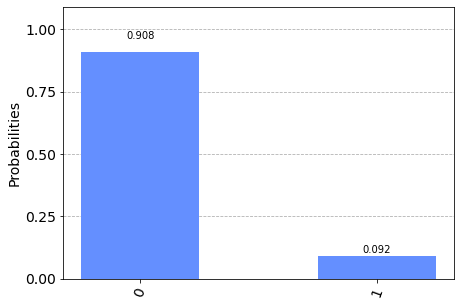

In [67]:
#Genarate the quantum circuit to estimate the inner product
qc_quantum_vector1,qc_quantum_vector2=initializer_circuit(num_qubits,quantum_vector1,quantum_vector2)

repetitions=20000 #We need to decide how many times we want to run the quantum circuit experiment. Value 20000 is chosen arbitrarily
                  #Maximum value allowed in IBM quantum simulator is 65536

inner_product_circuit=get_main_circuit(qc_quantum_vector1,qc_quantum_vector2,num_qubits)
counts=measure_step(inner_product_circuit,repetitions)
p=counts['0']/(counts['0']+counts['1'])
#print(counts['0'],counts['1'],p)

estimated_inner_product_with_dummy=2*p-1
    
estimated_inner_product_without_dummy=estimated_inner_product_with_dummy- vector1d[-1]*vector2d[-1] 

                
print('\nEstimated_inner_product ',estimated_inner_product_without_dummy,'numpy inner product: ', np.inner(vector1,vector2))
print('Qiskit circuit depth to estimate the inner product: ', inner_product_circuit.depth())

    
display(plot_histogram(counts))



**Lets draw the quantum circuit**

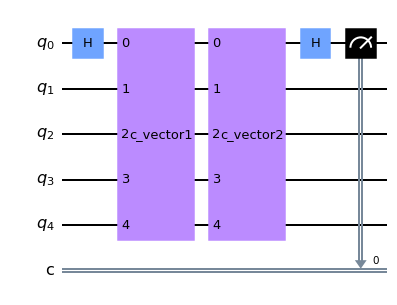

In [68]:
inner_product_circuit=get_main_circuit(qc_quantum_vector1,qc_quantum_vector2,num_qubits)
inner_product_circuit.draw('mpl')

**Now let's run the quantum circuit on a real quantum device**

*I have found that the real quantum device with more that 5 qubits are unavilable*

In [ ]:
# Load our saved IBMQ accounts and get the least busy backend device with greater than or equal to num_qubits+1 qubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (num_qubits+1) and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

repetitions=20000 #Chose a value eqaul to or below 20000,maximum shots allowed is 20000
transpiled_circuit = transpile(inner_product_circuit, backend, optimization_level=1)
job = backend.run(transpiled_circuit,shots=repetitions) 
job_monitor(job, interval=2)

# Get the results of the computation
results = job.result()
counts = results.get_counts()

p=counts['0']/(counts['0']+counts['1'])
#print(counts['0'],counts['1'],p)

estimated_inner_product_with_dummy=2*p-1
    
estimated_inner_product_without_dummy=estimated_inner_product_with_dummy- vector1d[-1]*vector2d[-1] 

                
print('\nEstimated_inner_product ',estimated_inner_product_without_dummy,'numpy inner product: ', np.inner(vector1,vector2))
print('Quantum circuit depth on real quantum device to estimate the inner product: ', transpiled_circuit.depth())

    
display(plot_histogram(counts))

ibmqfactory.load_account:WARNING:2021-12-01 11:37:08,725: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_belem
Job Status: job is actively running

In [ ]:
#lets decompose the entire circuit and print \
#inner_product_circuit = inner_product_circuit.decompose()
#inner_product_circuit.draw('mpl')